<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/Deep_Convolutional_Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 05th Nov, 2023
# Ref: https://www.tensorflow.org/tutorials/generative/dcgan
# https://pyimagesearch.com/2021/11/11/get-started-dcgan-for-fashion-mnist/

## Install software
Needed to create gifs

In [1]:
# 0.0
! pip install imageio
! pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_dyoag74
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-_dyoag74
  Resolved https://github.com/tensorflow/docs to commit 60abeb06e500fa5edbbac374fc0d8142c8322aef
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.10.27.81990-py3-none-any.whl size=184144 sha256=bcaab56741b87f457d4e8a1c41c4cc234ea1d114fc842b4ebd919a2b800f555b
  Stored in directory: /tmp/pip-ephem-wheel-cache-d7nu2l9l/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


## How GAN's ate trained?

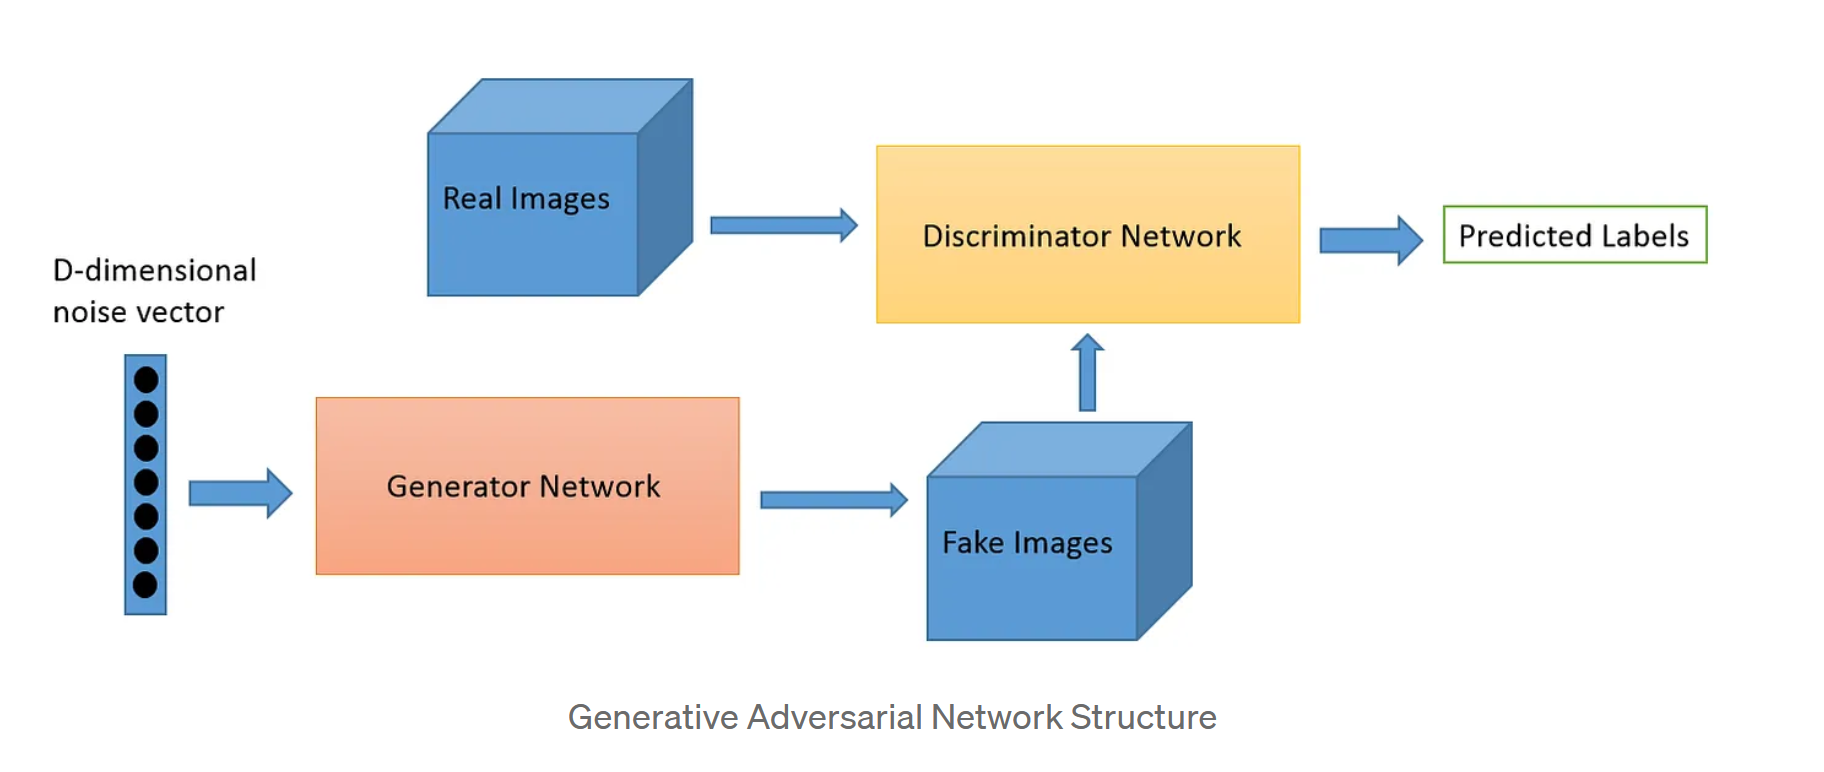

>In the first phase we train the discriminator, A batch of real images is sampled from the training set and is completed with an equal number of fake images produced by the generator. The labels are set to 0 for fake images and 1 for real images and the discriminator is trained on this labeled batch for one step, using the binary cross-entropy loss. Importantly, backpropogation omly optimizes the weights of the discriminator during this pahse.  
>In the second phase, we train the generator. We first use it to produce another batch of fake images, and once again the discriminator is used to tell whether the images are fake or real. This time we do not add the real images in the batch, and all the labels are set to 1 (real): in other words we want the generator to produce images tha the discriminator will (wrongly) believe to be real! Crucially, the weights of the discriminator are frozen during this step, so backpropogation only affects the weights of the generator.

The generator never actually sees any real images, yet it gradually learns to produce convincing fake images. All it gets is the gradient flowing back through the discriminator. Fortunately, the better the dicriminator gets, the more information abouth the real images is contained in these secondhand gradients, so the generator can make significant progress.   
Another image is below:

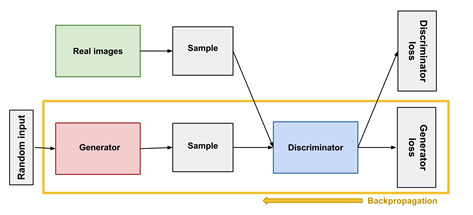

## Max Unpooling

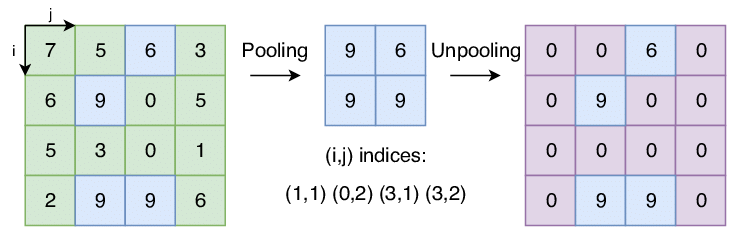

### How Convolutional layer works

Feature map size calculation:  
Output feature map size = 1 + (Input Size - Filter size + 2 * Padding) /

In [ ]:
# 0.1
from IPython import display
display.Image(url='https://b2633864.smushcdn.com/2633864/wp-content/uploads/2021/12/2_strided_conv_do_not_smush.gif?size=395x381&lossy=2&strip=1&webp=1')


### How Convolutional Transpose layer works  
Also called Deconvolution
See [here](https://blog.paperspace.com/transpose-convolution/)

Image size calculation:  

>In the equation for convolutioanl output size, replace output by input and vice versa. Then, rearrange variables: <br>
>input size = 1 + (Output size - Filter size + 2 * Padding) / Stride
To get:  
>Transpose Convolution Output Size = (Input Size - 1) * Strides + Filter Size - 2 * Padding + Ouput Padding

In [ ]:
# 0.2
display.Image(url='https://b2633864.smushcdn.com/2633864/wp-content/uploads/2021/12/3_fractional_strided_conv_do_not_smush.gif?size=395x449&lossy=2&strip=1&webp=1')

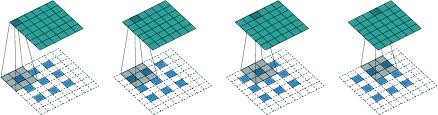

In [ ]:
# 1.0 Call libraries:


import numpy
import tensorflow as tf
from tensorflow.keras import layers

# 1.0.1 Image plotting related
import imageio
import matplotlib.pyplot as plt
import PIL

# 1.0.2 File system related
import os
import glob

# 1.0.3 Others
import time
from IPython import display

In [ ]:
# 1.1 Display multiple outputs from a cell

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Load data
We will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.


In [ ]:
# 2.0 Forget test images:

(train_images, train_labels) , (_,_) = tf.keras.datasets.mnist.load_data()
train_images.shape  # (60000, 28, 28)

In [ ]:
# 2.1 Reshape and normalize the images
train_images = train_images.reshape(train_images.shape[0], 28,28,1).astype('float32')

# 2.2 We will use tanh as output activation function:
train_images = (train_images - 127.5)/127.5

# 2.3 Recheck
train_images.min() ; train_images.max()

1.0

### Dataset transformation
Transform the dataset to tensorflow dataset format. BUFFER_SIZE is important for shuffling the data. This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, set the buffer size equal to the full size of the dataset.   
As tensorflow is meant for vary large datasets, spread over many machines, it is not practical to shuffle the whole dataset again and again at the begiining of each epoch.

In [ ]:
# 3.1
BUFFER_SIZE = 60000  # Needed for shuffling
BATCH_SIZE = 256

In [ ]:
# 3.2 Shuffle the dataset and also batch it:

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).  \
                                shuffle(BUFFER_SIZE).  \
                                batch(BATCH_SIZE)

## Model creation

### Generator model

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

See [here](https://pyimagesearch.com/2021/11/11/get-started-dcgan-for-fashion-mnist/)<br>
And [here](https://blog.paperspace.com/transpose-convolution/)

## Original paper [here](https://arxiv.org/pdf/1511.06434.pdf)

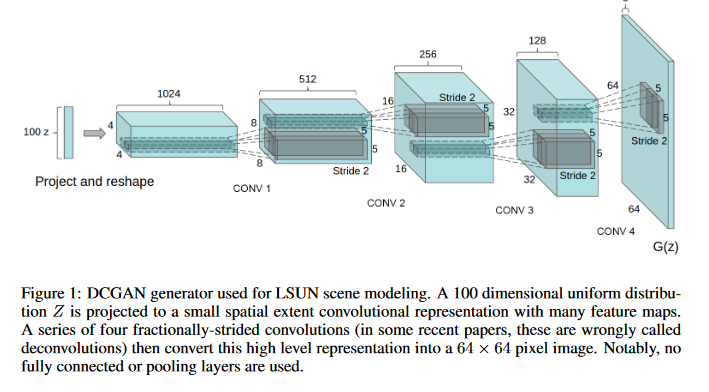

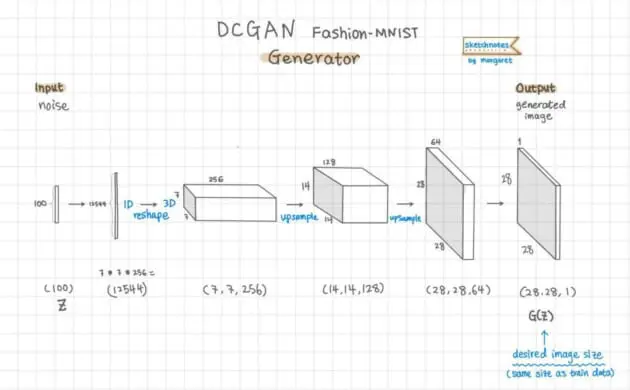

Size of output layer:  
Reference StackOverflow [here](https://datascience.stackexchange.com/a/36847). Here is the correct formula for computing the size of the output with tf.layers.conv2d_transpose():

>Padding==Same: <br>
>H = H1 * stride <br>


>Padding==Valid <br>
>H = (H1-1) * stride + HF <br>

where, H = output size, H1 = input size, HF = height of filter.


In [ ]:
# 4.0
def make_generator_model():
    model = tf.keras.Sequential()

    # Out generator receives 1-D random inputs
    # Hence first hidden layer is a Dense vector:
    # Call this 1-D as latent space:

    # Input shape is 100
    # Size of Ist Dense layer: 7 * 7 * 256 (=12,544)
    #   This size is dictated by out final output 28*28*1
    #     See above diagram

    # Layer 1
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())  # Note the activation follows BatchNormalization()
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    # Layer 2
    # H = H1 * stride = 7 *1 = 7
    model.add(layers.Conv2DTranspose(128,
                                     (5, 5),
                                     strides=(1, 1),
                                     padding='same', # Thus no change in shape of 7 X 7
                                     use_bias=False)
                                     )
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Layer 3
    # H = H1 * stride = 7 * 2 = 14
    model.add(layers.Conv2DTranspose(64,
                                     (5, 5),
                                     strides=(2, 2),
                                     padding='same',
                                     use_bias=False)
                                    )

    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Layer 4
    # H = H1 * strides = 14 * 2 = 28
    model.add(layers.Conv2DTranspose(1,
                                     (5, 5),
                                     strides=(2, 2),
                                     padding='same',
                                     use_bias=False,
                                     activation='tanh')
                                    )
    assert model.output_shape == (None, 28, 28, 1)
    return model

Use the (as yet untrained) generator to create an image.

In [ ]:
# 4.1 Create the generator model now:

generator = make_generator_model()

In [ ]:
# 4.2 Get some inputs:

noise = tf.random.normal([1, 100])
noise.shape
noise

*tf.keras.Model* class behaves as a function due to *call()* method. See [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model#call). Internally, *model.fit()* must also be calling the <i>call()</i> method, feeding it an input and getting the output.

In [ ]:
# 5.0 This code checks if noise can be fed directly
#       to a Sequential 'model'. Remember every layer
#         is a function:

noise = tf.random.normal([1, 16])
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(16,)))
model.add(tf.keras.layers.Dense(8))

# 5.0.1 As there is no feedback. Remember all layers are functions

model(noise, training = False)

<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[ 0.05543178,  0.04946762, -0.4127532 ,  1.4184586 ,  1.4518516 ,
         0.38095665,  0.03645742, -0.28005475]], dtype=float32)>

*Sequential()* groups a linear stack of layers into a tf.keras.Model. tf.keras.*Model()* has a *call()* method. This *call()* method allows the model to be called as a function with inputs. See the syntax of *call()* method [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model#call). Also see [this](https://stackoverflow.com/a/59407927/3282777) discussion on StackOverflow. Hence the code *generator(noise, training=False)* below:

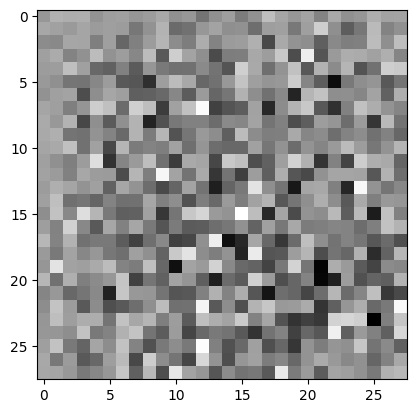

In [ ]:
# 5.0.2 Feed noise into generator and check output:

generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training= False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray') ;

## Discriminator
The discriminator is a CNN-based image classifier.

In [ ]:
# 6.0
def make_discriminator_model():

    model = tf.keras.Sequential()

    # Feature engineering layer
    model.add(layers.Conv2D(
                            64,
                            (5, 5),
                            strides=(2, 2),
                            padding='same',
                            input_shape=[28, 28, 1]
                            )
              )

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(
                            128,
                            (5, 5),
                            strides=(2, 2),
                            padding='same'
                            )
              )

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Feature classification layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
# 6.1
discriminator = make_discriminator_model()
decision = discriminator(generated_image)  # By default training = None
print (decision)

tf.Tensor([[0.00109807]], shape=(1, 1), dtype=float32)


The *from_logits* parameter in BinaryCrossentropy determines whether the input *y_pred* is a probability distribution or a logit value. A logit value is the output of a linear regression model, which is not normalized and can take any value between negative and positive infinity.   <br>
[Here](https://saturncloud.io/blog/tensorflow-understanding-the-fromlogits-parameter-in-sparse-categorical-crossentropy/) is a tensorflow blog on *from_logits* parameter

In [ ]:
# 6.2 This method returns a helper function to compute cross entropy loss
#      Our NN output can be upto infinity

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Loss function

Minimax Loss

In the paper that introduced GANs, the generator tries to minimize the following function while the discriminator tries to maximize it:

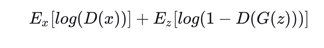



Also written as below. Generator tries to minimize it while discrimantor tries to maximise it. Hence also known as MinMax loss.:

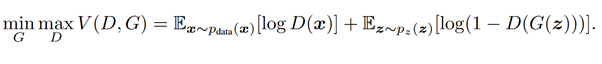

In this function:

> 1.0 D(x) is the discriminator's estimate of the probability that real data instance x is real. Discriminator must maximise it for log(0.2) is negative while log(1.0) is 0.0. (Note that cross entropy is loss function also has negative signs attached (see below):
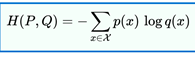

>2.0 Ex is the expected value over all real data instances.  

>3.0 G(z) is the generator's output when given noise z.  

>4.0 D(G(z)) is the discriminator's estimate of the probability that a fake instance is real.  

>5.0 Ez is the expected value over all random inputs to the generator (in effect, the expected value over all generated fake instances G(z)).  

>6.0 The formula derives from the cross-entropy between the real and generated distributions.  


The generator can't directly affect the log(D(x)) term in the function, so, for the generator, minimizing the loss is equivalent to minimizing log(1 - D(G(z))). Minimizing log(1 - D(G(z))) implies D(G(z)) is as close to one as possible or discriminator is being fooled into believing that fake image is real.

## Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [ ]:
# 7.0 Discriminator receives two kinds of images:
def discriminator_loss(real_output, fake_output):

    # Some genuine images were also predicted as fake:
    # tf.ones_like(real_output) is like np.ones_like(real_output)
    # That is, as many ones as the number of real_output

    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # Some fake images were also predicted as genuine:
    # tf.zeros_like(fake_output) is like np.zeros_like(fake_output)
    # That is, as many ones as the number of fake_output

    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    # So total loss is:
    total_loss = real_loss + fake_loss
    return total_loss

## Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
# 7.1
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizers

The discriminator and the generator optimizers are different since you will train two networks separately.

In [ ]:
# 7.2 Define optimizer functions:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Save checkpoint

This demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted. Why save optimizer? The optimizer state is the optimizer's momentum vector or similar history-tracking properties.

For example, the Adam optimizer tracks moving averages of the gradient and squared gradient. If you start training a model without restoring these data, the optimizer will operate differently. The updates will be different, so the optimizer will proceed along a different trajectory. See StackOverflow [here](https://stats.stackexchange.com/a/444330)

In [ ]:
# 7.2.1 What is my pwd:
!pwd

In [ ]:
# 7.3 Where will NN state would be stored?

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator
                                 )

/content


## Define training loop

In [ ]:
# 8.0
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16



The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [ ]:
# 8.1 You will reuse this seed overtime (so it's easier)
#      to visualize progress in the animated GIF)

seed = tf.random.normal(shape = [num_examples_to_generate, noise_dim])     # Default mean = 0, stddev =1
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[-0.11305395, -1.5978923 ,  0.07246045, ...,  0.15362366,
         0.36656836, -0.0203163 ],
       [-0.61925745,  3.404574  , -0.83941746, ...,  0.9326486 ,
         0.0345084 , -1.1204468 ],
       [-0.3778859 , -0.15131874, -0.73696715, ...,  0.68036145,
         1.6693724 , -0.5446628 ],
       ...,
       [ 1.057056  , -0.27903974, -0.6828208 , ...,  0.34601244,
        -1.0976734 , -0.5387259 ],
       [-1.007759  ,  0.33428726,  0.11292344, ..., -1.4188958 ,
        -0.3849238 ,  0.95779157],
       [ 0.027029  ,  1.4974972 , -0.74915385, ...,  0.4377944 ,
         0.53604895,  0.07998198]], dtype=float32)>

About with statement see [here](https://builtin.com/software-engineering-perspectives/what-is-with-statement-python).   

What Is the *With* Statement in Python? <br>
In Python, the *with* statement replaces a *try-catch *block with a concise shorthand. More importantly, it ensures closing resources right after processing them. A common example of using the with statement is reading or writing to a file. A function or class that supports the with statement is known as a context manager. A context manager allows you to open and close resources right when you want to. For example, the *open()* function is a context manager. When you call the *open()* function using the with statement, the file closes automatically after you’ve processed the file. Similarly *tf.GradientTape()* is a context manager.

Most models are made of layers. Layers are functions with a known mathematical structure that can be reused and have *trainable variables*. Any variable that can be modified during training of the model is known as a *trainable variable*.

The distinction between *trainable variables* and non-trainable variables is used to let Optimizers know which variables they can act upon.

In [ ]:
# 9.0 train_step:
#      At each step feed images, calculate loss, calculate
#       gradients and then apply gradients or change weights:

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# tf.function is a decorator function provided by Tensorflow 2.0
# that converts regular python code to a callable Tensorflow graph function,
#  which is usually more performant and python independent.
#   It is used to create portable Tensorflow models.


# Get a batch of images:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

   # 9.0.1 Open gradient recorder:
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      # Please see para 4.2 for 'noise' generation
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # 9.0.2 What are trainable_variables? See here
    #       https://stackoverflow.com/a/74311971/3282777

    # 9.0.3 Calculate gradients at output:
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 9.0.4 Apply the gradients using backpropogation:
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
# 10.0
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  img_predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(img_predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(img_predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


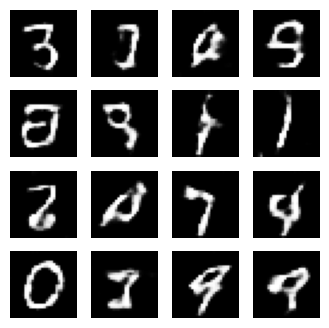

In [ ]:
train(train_dataset, EPOCHS)


In [ ]:
g = np.ones([3,2,4])
g
g[1, : , 0] * 3.5

In [ ]:
x = tf.constant(3.0)
with tf.GradientTape() as g:
  g.watch(x)   # g is to watch x
  y = x * x
  print(y)
dy_dx = g.gradient(y, x)
print(dy_dx)



In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/GradientTape
# https://www.tensorflow.org/guide/tensor

x = tf.constant([2.0, 3.0, 4.0])
with tf.GradientTape() as g:
  g.watch(x)   # g is to watch x
  y = x * x
  print(y)
dy_dx = g.gradient(y, x)
print(dy_dx)

